In [597]:
# Reload the evaluation module using ipython magic func
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import sklearn
import statsmodels as sm
import numpy as np
import sktime
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import pickle
from scipy import stats

from typing import List
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from sklearn.model_selection import train_test_split
from sktime.split import temporal_train_test_split, ExpandingWindowSplitter
from sktime.forecasting.model_evaluation import evaluate
from sktime.performance_metrics.forecasting import MeanAbsoluteScaledError
from sktime.performance_metrics.forecasting import MeanSquaredError
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError
from autots import AutoTS
from ydata_profiling import ProfileReport
from darts.dataprocessing.transformers import MIDAS
from darts.models import RandomForest
from darts import TimeSeries
from darts.models import TiDEModel

from helpers import evaluation, charting

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Todo:
1. Get the financial variables
2. Get the MIDAS scoring setup
3. RMSE scores over each horizon for each model
4. Do it for each dataset
5. And when dummying/engineering out COVID.

# Work Based Project
Initial Development Notebook

Plan outline:
1. Load the data
2. Clean the data
3. Reshape, resample (turn from monthly to quarterly)
4. Specify our model
5. Fit model
6. Predict
7. Evaluation (rolling OOS)



### Step 1: Load the data

In [598]:
input_data_dict = pd.read_excel('input data.xlsx', sheet_name=None)

for sheet_name, df in input_data_dict.items():
    print(f"Sheet name: {sheet_name}")

Sheet name: Instructions
Sheet name: dep
Sheet name: mind
Sheet name: quarterly
Sheet name: mserv
Sheet name: mprod
Sheet name: mconst
Sheet name: weights
Sheet name: GDP - low-level aggregates


### Step 2: Clean the data

In [599]:
# This is the first estimate of Quarterly GDP each quarter, turned into a time series
qgdp = input_data_dict['dep']

qgdp.index = pd.to_datetime(qgdp['Date'])
qgdp = qgdp.drop(['Date'], axis=1)
qgdp = qgdp.dropna()
qgdp = qgdp.rename(columns={'gdp': 'Quarterly GDP growth'})

qgdp.info()
qgdp.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 137 entries, 1990-03-31 to 2024-03-31
Data columns (total 1 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Quarterly GDP growth  137 non-null    float64
dtypes: float64(1)
memory usage: 2.1 KB


,Quarterly GDP growth
Date,
1990-03-31,0.462645
1990-06-30,0.990487
1990-09-30,-1.282870
1990-12-31,-0.928221
1991-03-31,-0.470855


In [600]:
# Monthly indicators
m_ind = input_data_dict['mind']

m_ind.index = pd.to_datetime(m_ind['Date'])
m_ind = m_ind.drop(['Date'], axis=1)
m_ind = m_ind.dropna()

m_ind

,cipsto,cipste,cipstn,cbito,cbite,lbbba
Date,,,,,,
2003-10-31,59.019121,72.009759,57.887877,-8.0,8.0,53.0
2003-11-30,59.032192,74.245034,59.223734,2.0,15.0,38.0
2003-12-31,58.246338,75.003468,58.332699,7.0,18.0,62.0
2004-01-31,59.260138,76.271992,60.703809,20.0,29.0,53.0
2004-02-29,58.443636,73.355040,58.819207,18.0,33.0,55.0
...,...,...,...,...,...,...
2024-01-31,52.900000,70.600000,52.200000,-11.0,3.0,58.0
2024-02-29,52.979231,74.968075,52.261940,-6.0,5.0,52.0
2024-03-31,52.900000,73.800000,52.000000,-12.0,11.0,55.0


In [601]:
# Quarterly indicators
q_ind = input_data_dict['quarterly']

q_ind.index = pd.to_datetime(q_ind['Date'])
q_ind = q_ind.drop(['Date'], axis=1)
# q_ind = q_ind.dropna()

q_ind.info()
q_ind.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 137 entries, 1990-03-31 to 2024-03-31
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   bccto   137 non-null    float64
 1   bccte   137 non-null    float64
 2   bcctn   137 non-null    float64
dtypes: float64(3)
memory usage: 4.3 KB


,bccto,bccte,bcctn
Date,,,
1990-03-31,18.123964,41.704425,16.628885
1990-06-30,9.697203,40.272566,7.574371
1990-09-30,-2.484248,25.056637,-7.316107
1990-12-31,-8.483257,15.192920,-16.487859
1991-03-31,-23.884248,20.056637,-25.688354


In [602]:
# monthly GDP services
m_serv = input_data_dict['mserv']

m_serv.index = pd.to_datetime(m_serv['Date'])
m_serv = m_serv.drop(['Date'], axis=1)

m_serv = m_serv.dropna(axis=1, how='all') # Drop all columns where all values are empty
m_serv = m_serv.dropna(axis=0, how='all') # Drop all rows where all values are empty

# Make it the right shape
rows_to_drop = m_serv.loc[m_serv.index < pd.Timestamp("August 2000")]
m_serv = m_serv.drop(rows_to_drop.index)

columns_to_drop = pd.to_datetime(m_serv.columns) < pd.Timestamp("August 2000")
m_serv = m_serv.drop(m_serv.loc[:, columns_to_drop].columns, axis=1)

m_serv.info()
m_serv.head()

# Column is the revision release data
# Rows are the values

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 285 entries, 2000-08-31 to 2024-04-30
Columns: 285 entries, 2000-08-01 00:00:00 to 2024-04-01 00:00:00
dtypes: float64(285)
memory usage: 636.8 KB


,2000-08-01,2000-09-01,2000-10-01,2000-11-01,2000-12-01,2001-01-01,2001-02-01,2001-03-01,2001-04-01,2001-05-01,...,2023-07-01,2023-08-01,2023-09-01,2023-10-01,2023-11-01,2023-12-01,2024-01-01,2024-02-01,2024-03-01,2024-04-01
Date,,,,,,,,,,,,,,,,,,,,,
2000-08-31,0.9,1.0,1.0,1.0,1.0,1.1,1.1,1.1,1.1,1.1,...,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8
2000-09-30,NaN,-0.3,-0.1,-0.1,-0.1,-0.1,-0.1,-0.1,-0.1,-0.1,...,-0.6,-0.6,-0.6,-0.6,-0.6,-0.6,-0.6,-0.6,-0.6,-0.6
2000-10-31,NaN,NaN,0.1,0.0,0.1,0.2,0.2,0.2,0.2,0.2,...,-0.1,-0.1,-0.1,-0.1,-0.1,-0.1,-0.1,-0.1,-0.1,-0.1
2000-11-30,NaN,NaN,NaN,0.7,0.9,0.6,0.6,0.6,0.6,0.6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2000-12-31,NaN,NaN,NaN,NaN,-0.6,-0.6,-0.6,-0.6,-0.6,-0.6,...,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6


In [603]:
# monthly GDP production
m_prod = input_data_dict['mprod']

m_prod.index = pd.to_datetime(m_prod['Date'])
m_prod = m_prod.drop(['Date'], axis=1)

m_prod = m_prod.dropna(axis=1, how='all') # Drop all columns where all values are empty
m_prod = m_prod.dropna(axis=0, how='all') # Drop all rows where all values are empty

# Make it the right shape
rows_to_drop = m_prod.loc[m_prod.index < pd.Timestamp("August 2000")]
m_prod = m_prod.drop(rows_to_drop.index)

columns_to_drop = pd.to_datetime(m_prod.columns) < pd.Timestamp("August 2000")
m_prod = m_prod.drop(m_prod.loc[:, columns_to_drop].columns, axis=1)

m_prod.info()
m_prod.head()

# Column is the revision release data
# Rows are the values

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 285 entries, 2000-08-31 to 2024-04-30
Columns: 285 entries, 2000-08-01 00:00:00 to 2024-04-01 00:00:00
dtypes: float64(285)
memory usage: 636.8 KB


,2000-08-01,2000-09-01,2000-10-01,2000-11-01,2000-12-01,2001-01-01,2001-02-01,2001-03-01,2001-04-01,2001-05-01,...,2023-07-01,2023-08-01,2023-09-01,2023-10-01,2023-11-01,2023-12-01,2024-01-01,2024-02-01,2024-03-01,2024-04-01
Date,,,,,,,,,,,,,,,,,,,,,
2000-08-31,0.6,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,...,1.312259,1.312259,1.312259,1.312259,1.312259,1.312259,1.312259,1.312259,1.312259,1.312259
2000-09-30,NaN,-1.1,-1.0,-1.0,-0.9,-0.8,-0.8,-0.8,-0.8,-0.8,...,-0.434952,-0.434952,-0.434952,-0.434952,-0.434952,-0.434952,-0.434952,-0.434952,-0.434952,-0.434952
2000-10-31,NaN,NaN,-0.2,-0.2,0.0,-0.1,-0.1,-0.1,-0.1,-0.1,...,0.408371,0.408371,0.408371,0.408371,0.408371,0.408371,0.408371,0.408371,0.408371,0.408371
2000-11-30,NaN,NaN,NaN,0.1,0.1,0.1,0.1,0.1,0.1,0.1,...,1.030745,1.030745,1.030745,1.030745,1.030745,1.030745,1.030745,1.030745,1.030745,1.030745
2000-12-31,NaN,NaN,NaN,NaN,-0.6,-0.6,-0.6,-0.6,-0.6,-0.6,...,2.532208,2.532208,2.532208,2.532208,2.532208,2.532208,2.532208,2.532208,2.532208,2.532208


In [604]:
# monthly GDP construction
m_const = input_data_dict['mconst']

m_const.index = pd.to_datetime(m_const['Date'])
m_const = m_const.drop(['Date'], axis=1)

m_const = m_const.dropna(axis=1, how='all') # Drop all columns where all values are empty
m_const = m_const.dropna(axis=0, how='all') # Drop all rows where all values are empty

# Make it the right shape
rows_to_drop = m_const.loc[m_const.index < pd.Timestamp("August 2000")]
m_const = m_const.drop(rows_to_drop.index)

columns_to_drop = pd.to_datetime(m_const.columns) < pd.Timestamp("August 2000")
m_const = m_const.drop(m_const.loc[:, columns_to_drop].columns, axis=1)

m_const.info()
m_const.head()

# Column is the revision release data
# Rows are the values

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 285 entries, 2000-08-31 to 2024-04-30
Columns: 285 entries, 2000-08-01 00:00:00 to 2024-04-01 00:00:00
dtypes: float64(285)
memory usage: 636.8 KB


,2000-08-01,2000-09-01,2000-10-01,2000-11-01,2000-12-01,2001-01-01,2001-02-01,2001-03-01,2001-04-01,2001-05-01,...,2023-07-01,2023-08-01,2023-09-01,2023-10-01,2023-11-01,2023-12-01,2024-01-01,2024-02-01,2024-03-01,2024-04-01
Date,,,,,,,,,,,,,,,,,,,,,
2000-08-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2000-09-30,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2000-10-31,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2000-11-30,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2000-12-31,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [605]:
def rescale_weights(array_of_weights):
    """Rescales the weights to add up to 1"""
    return array_of_weights / sum(array_of_weights)

In [606]:
# Load the weights and transform to monthly from quarterly 
gdp_weights = input_data_dict['weights']

gdp_weights.index = pd.to_datetime(gdp_weights['Date'])
gdp_weights = gdp_weights.drop(['Date'], axis=1)
gdp_weights = gdp_weights.resample(rule='m').ffill()


gdp_weights = gdp_weights.apply(
    func=rescale_weights, # Function to apply
    axis=1, # Apply function to each row
    raw=True, # Pass the data as a array rather than series
    result_type='broadcast', # Keep the shape of the DF the same
)

# Reshape:
weights_to_drop = gdp_weights.loc[(gdp_weights.index < pd.Timestamp("August 2000")) | (gdp_weights.index > m_serv.index[-1])]
gdp_weights = gdp_weights.drop(weights_to_drop.index)

gdp_weights.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 285 entries, 2000-08-31 to 2024-04-30
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   w_serv   285 non-null    float64
 1   w_prod   285 non-null    float64
 2   w_const  285 non-null    float64
dtypes: float64(3)
memory usage: 8.9 KB


/var/folders/df/j998nyn11sdf0w5cf48pny6m0000gn/T/ipykernel_41501/1878564410.py:6: FutureWarning: 'm' is deprecated and will be removed in a future version, please use 'ME' instead.
  gdp_weights = gdp_weights.resample(rule='m').ffill()


In [607]:
# combine services, production and construction with their weights, to form monthly GDP
m_gdp = m_serv.mul(gdp_weights['w_serv'], axis=0) + m_prod.mul(gdp_weights['w_prod'], axis=0)  + m_const.mul(gdp_weights['w_const'], axis=0)

m_gdp

,2000-08-01,2000-09-01,2000-10-01,2000-11-01,2000-12-01,2001-01-01,2001-02-01,2001-03-01,2001-04-01,2001-05-01,...,2023-07-01,2023-08-01,2023-09-01,2023-10-01,2023-11-01,2023-12-01,2024-01-01,2024-02-01,2024-03-01,2024-04-01
Date,,,,,,,,,,,,,,,,,,,,,
2000-08-31,0.836115,0.872229,0.872229,0.872229,0.872229,0.950934,0.950934,0.950934,0.950934,0.950934,...,0.909086,0.909086,0.909086,0.909086,0.909086,0.909086,0.909086,0.909086,0.909086,0.909086
2000-09-30,NaN,-0.470361,-0.291656,-0.291656,-0.270361,-0.249066,-0.249066,-0.249066,-0.249066,-0.249066,...,-0.564853,-0.564853,-0.564853,-0.564853,-0.564853,-0.564853,-0.564853,-0.564853,-0.564853,-0.564853
2000-10-31,NaN,NaN,0.036115,-0.042590,0.078705,0.136115,0.136115,0.136115,0.136115,0.136115,...,0.008258,0.008258,0.008258,0.008258,0.008258,0.008258,0.008258,0.008258,0.008258,0.008258
2000-11-30,NaN,NaN,NaN,0.572229,0.729639,0.493525,0.493525,0.493525,0.493525,0.493525,...,0.219498,0.219498,0.219498,0.219498,0.219498,0.219498,0.219498,0.219498,0.219498,0.219498
2000-12-31,NaN,NaN,NaN,NaN,-0.600000,-0.600000,-0.600000,-0.600000,-0.600000,-0.600000,...,1.011465,1.011465,1.011465,1.011465,1.011465,1.011465,1.011465,1.011465,1.011465,1.011465
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-0.029768,-0.029768,-0.036048,-0.036048,-0.036048
2024-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.202036,0.268512,0.327646,0.327646
2024-02-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.110611,0.250904,0.250904


### Step 3: Reshape the data

#### Existing dataset
Same as within C-MIDAS already

In [608]:
# Resample the quarterly indicators
# q_resampled_ind = q_ind.resample('ME').ffill()


In [609]:
# Y =  qgdp.resample('ME').ffill()
# Y = Y.loc[Y.index >= X.index[0]]
# Y.index.freq = 'ME'

# Y = Y.squeeze()
# Y

Y_q = qgdp.squeeze()
Y_q.index.freq = 'QE'

Y = Y_q.resample('ME').ffill()
Y.index.freq = 'ME'

In [610]:
test_df = m_ind.merge(
    q_ind.resample('ME').ffill(), 
    left_index=True, 
    right_index=True, 
    how='inner'
).merge(
    m_gdp[m_gdp.columns[-1]],
    left_index=True,
    right_index=True,
    how='inner'
)

X = test_df.rename({test_df.columns[-1]: 'm_gdp'}, axis=1)
X.index.freq = 'ME' # type: ignore


# # Midas implementation for testing
# midas = MIDAS(low_freq="QE")
# X_q = midas.fit_transform(TimeSeries.from_dataframe(X)).pd_dataframe()
X_q = X.resample('QE').mean()

X_q.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 82 entries, 2003-12-31 to 2024-03-31
Freq: QE-DEC
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   cipsto  82 non-null     float64
 1   cipste  82 non-null     float64
 2   cipstn  82 non-null     float64
 3   cbito   82 non-null     float64
 4   cbite   82 non-null     float64
 5   lbbba   82 non-null     float64
 6   bccto   82 non-null     float64
 7   bccte   82 non-null     float64
 8   bcctn   82 non-null     float64
 9   m_gdp   82 non-null     float64
dtypes: float64(10)
memory usage: 7.0 KB


In [611]:
X_q = X_q.loc[X_q.index >= Y.index[0]]
Y_q = Y_q.loc[Y_q.index >= X_q.index[0]]
Y = Y.loc[Y.index >= X.index[0]]

Y_q.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 82 entries, 2003-12-31 to 2024-03-31
Freq: QE-DEC
Series name: Quarterly GDP growth
Non-Null Count  Dtype  
--------------  -----  
82 non-null     float64
dtypes: float64(1)
memory usage: 1.3 KB


#### Expanded dataset

In [612]:
# Load the extra data
expanded_data = pd.ExcelFile('control_output-change.xlsm')

with expanded_data as xl:
    expanded_qind = pd.read_excel(xl, 'qind', index_col=0).dropna()
    expanded_mind = pd.read_excel(xl, 'mind', index_col=0).dropna()

expanded_mind['m_gdp'] = X['m_gdp']

In [613]:
expanded_X_q = pd.concat(
    [expanded_qind, expanded_mind.resample('QE').mean()],
    axis=1
).dropna()

expanded_X_q = expanded_X_q.loc[expanded_X_q.index.intersection(Y_q.index)]
expanded_X_q.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 82 entries, 2003-12-31 to 2024-03-31
Freq: QE-DEC
Data columns (total 32 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   bccto    82 non-null     float64
 1   bccte    82 non-null     float64
 2   bcctn    82 non-null     float64
 3   inflp    82 non-null     float64
 4   infle    82 non-null     float64
 5   bus      82 non-null     float64
 6   cipsto   82 non-null     float64
 7   cipste   82 non-null     float64
 8   cipstn   82 non-null     float64
 9   cbito    82 non-null     float64
 10  cbite    82 non-null     float64
 11  lbbba    82 non-null     float64
 12  brc      82 non-null     float64
 13  rs       82 non-null     float64
 14  pmiemp   82 non-null     float64
 15  memp     82 non-null     float64
 16  mbrick   82 non-null     float64
 17  gfk      82 non-null     float64
 18  cpi      82 non-null     float64
 19  ntnw     82 non-null     float64
 20  hali     82 non-null   

In [614]:
# Drop Business stuff since it has crazy numbers
expanded_X_q.drop(columns=['bus'], inplace=True)

### Step 4: Transform the data

In [615]:
# mapping series
series_properties = {
    'bccto':  'balance',
    'bccte':  'balance',
    'bcctn':  'balance',
    'inflp':  'pct_change',
    'infle':  'pct_change',
    'bus':    'level',
    'cipsto': 'balance',
    'cipste': 'balance',
    'cipstn': 'balance',
    'cbito':  'balance',
    'cbite':  'balance',
    'lbbba':  'balance',
    'brc':    'balance',
    'rs':     'pct_change',
    'pmiemp': 'balance',
    'memp':   'pct_change',
    'mbrick': 'level',
    'gfk':    'balance',
    'cpi':    'pct_change',
    'ntnw':   'pct_change',
    'hali':   'pct_change',
    'right':  'pct_change',
    'iop':    'index',
    'ios':    'index',
    'pmicco': 'balance',
    'pmiccno':'balance',
    'gold':   'level',
    'gbpusd': 'level',
    'copper': 'level',
    'oil':    'level',
    'gspc':   'level',
    'm_gdp':  'pct_change',
}

In [616]:
# Our three tables are: X_q, expanded_X_q, Y_q
from darts.dataprocessing import Pipeline
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller, BoxCox, Diff

scaler = Scaler()
differencer = Diff(lags=1)
normaliser = BoxCox(global_fit=False)
filler = MissingValuesFiller()

In [617]:
# expanded_X_q_trf = nn_trsf_pipe.fit_transform(TimeSeries.from_dataframe(expanded_X_q)).pd_dataframe()

# expanded_X_q_trf.plot(legend=False)

In [618]:
expanded_X_q_trf = expanded_X_q.copy()

for col in expanded_X_q:
    if series_properties[col] in ['level', 'index']:
        pipe = Pipeline([
            differencer,
            filler,
            # scaler,
            # normaliser,
            # filler,
        ])
        transformed_col = pipe.fit_transform(TimeSeries.from_series(expanded_X_q[col]))
        expanded_X_q_trf[col] = transformed_col.pd_series()
    
    if series_properties[col] in ['balance', 'pct_change']:
        pipe = Pipeline([
            filler,
            # normaliser,
            # scaler,
            # filler,
        ])
        transformed_col = pipe.fit_transform(TimeSeries.from_series(expanded_X_q[col]))
        expanded_X_q_trf[col] = transformed_col.pd_series()
    
expanded_X_q_trf = expanded_X_q_trf.dropna()

pipe = Pipeline([
    filler,
    # scaler,
    # filler,
])

Y_q_trf = pipe.fit_transform(TimeSeries.from_series(Y_q)).pd_series()

In [619]:
X_q_trf = X_q.copy()

for col in X_q:
    if series_properties[col] in ['level', 'index']:
        pipe = Pipeline([
            differencer,
            filler,
            scaler,
            filler,
        ])
        transformed_col = pipe.fit_transform(TimeSeries.from_series(expanded_X_q[col]))
        X_q_trf[col] = transformed_col.pd_series()
    
    if series_properties[col] in ['pct_change', 'balance']:
        pipe = Pipeline([
            filler,
            scaler,
            filler,
        ])
        transformed_col = pipe.fit_transform(TimeSeries.from_series(expanded_X_q[col]))
        X_q_trf[col] = transformed_col.pd_series()
    
X_q_trf = X_q_trf.dropna()

In [620]:
expanded_X_q_trf = expanded_X_q_trf.loc[expanded_X_q_trf.index >= Y_q_trf.index[0]]
expanded_Y_q_trf = Y_q_trf.loc[Y_q_trf.index >= expanded_X_q_trf.index[0]]

X_q_trf = X_q_trf.loc[X_q_trf.index >= Y_q_trf.index[0]]
Y_q_trf = Y_q_trf.loc[Y_q_trf.index >= X_q_trf.index[0]]
# Y_trf = Y.loc[Y.index >= X.index[0]]



# Y_q_trf = Y_q_trf.loc[Y_q_trf.index >= expanded_X_q_trf.index[0]]

# Y_q.info()

In [621]:
expanded_X_q_trf.info(), expanded_Y_q_trf.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 81 entries, 2004-03-31 to 2024-03-31
Freq: QE-DEC
Data columns (total 31 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   bccto    81 non-null     float64
 1   bccte    81 non-null     float64
 2   bcctn    81 non-null     float64
 3   inflp    81 non-null     float64
 4   infle    81 non-null     float64
 5   cipsto   81 non-null     float64
 6   cipste   81 non-null     float64
 7   cipstn   81 non-null     float64
 8   cbito    81 non-null     float64
 9   cbite    81 non-null     float64
 10  lbbba    81 non-null     float64
 11  brc      81 non-null     float64
 12  rs       81 non-null     float64
 13  pmiemp   81 non-null     float64
 14  memp     81 non-null     float64
 15  mbrick   81 non-null     float64
 16  gfk      81 non-null     float64
 17  cpi      81 non-null     float64
 18  ntnw     81 non-null     float64
 19  hali     81 non-null     float64
 20  right    81 non-null   

(None, None)

In [622]:
X_q_trf.info(), Y_q_trf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 82 entries, 2003-12-31 to 2024-03-31
Freq: QE-DEC
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   cipsto  82 non-null     float64
 1   cipste  82 non-null     float64
 2   cipstn  82 non-null     float64
 3   cbito   82 non-null     float64
 4   cbite   82 non-null     float64
 5   lbbba   82 non-null     float64
 6   bccto   82 non-null     float64
 7   bccte   82 non-null     float64
 8   bcctn   82 non-null     float64
 9   m_gdp   82 non-null     float64
dtypes: float64(10)
memory usage: 7.0 KB
<class 'pandas.core.series.Series'>
DatetimeIndex: 82 entries, 2003-12-31 to 2024-03-31
Freq: QE-DEC
Series name: Quarterly GDP growth
Non-Null Count  Dtype  
--------------  -----  
82 non-null     float64
dtypes: float64(1)
memory usage: 1.3 KB


(None, None)

In [623]:
expanded_X_q_trf.describe()

,bccto,bccte,bcctn,inflp,infle,cipsto,cipste,cipstn,cbito,cbite,...,iop,ios,pmicco,pmiccno,gold,gbpusd,copper,oil,gspc,m_gdp
count,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,...,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000
mean,13.751677,36.942775,9.364829,3.708466,3.001211,53.645221,67.813482,53.495161,3.008230,7.448560,...,-0.095118,0.384074,53.530693,53.438735,20.194706,-0.006016,0.035618,0.531073,46.634713,0.130426
std,16.644790,18.518758,16.685191,1.719918,0.706556,4.632638,5.081251,4.962917,17.798016,18.363548,...,2.561044,2.876022,4.730682,5.033400,72.457064,0.061816,0.353688,11.907692,145.296978,0.661149
min,-61.771256,-34.920354,-62.700318,1.848217,1.824156,30.498872,47.144923,31.065270,-53.666667,-63.666667,...,-12.578600,-20.168767,30.525621,30.855611,-170.714254,-0.275165,-1.290658,-48.753193,-466.096404,-2.887741
25%,8.795398,30.357595,4.003611,2.635754,2.498990,51.440293,64.848317,51.516258,-6.666667,-2.666667,...,-0.614567,0.090900,51.268990,51.443524,-28.695624,-0.036119,-0.133211,-2.968497,-13.559157,0.030338
50%,16.375142,40.155319,12.923570,3.094213,2.859374,54.286460,68.549926,54.200725,5.000000,9.666667,...,-0.015533,0.494267,54.140161,54.182833,17.474137,0.004944,0.059707,2.284950,50.435862,0.171178
75%,23.850363,49.647788,18.909407,4.363216,3.418741,56.561648,70.791113,56.345913,16.000000,19.000000,...,0.691267,0.761533,56.280096,56.110380,65.249540,0.033424,0.173014,6.701513,95.314619,0.237298
max,37.100999,61.746433,34.744009,9.615961,4.876947,61.931151,78.281401,62.545724,31.333333,37.666667,...,14.868400,12.063133,62.125326,62.619666,180.460254,0.163637,0.815137,24.288083,456.670902,3.579203


### Covid Dummy - COMMENTED OUT

In [624]:
# covid_dummy = pd.Series(
#     data=[0 if idx not in pd.date_range(start='2020-01-01', end='2021-12-31', freq='QE-DEC') else 1 for val, idx in zip(Y.values, Y.index)],
#     index=Y.index
# )

# X_q['covid_dummy'] = covid_dummy

# covid_dummy.plot()
# Y.plot()

### Dataset evaluation

In [625]:
# report = ProfileReport(
#     pd.concat([expanded_X_q, Y_q], axis=1),
#     tsmode=True
# )

# report.to_file('data_report_expanded.html')

# report

In [626]:
# b # reak our notebook execution

In [699]:
expanded_X_q_trf.to_csv('Expanded_Data.csv')

# Step 4: Specify our models
1. [X] AR model
2. Random Forest 
3. AutoTS
4. [X] XGBoost
5. TiDE
6. FB Prophet


In [627]:
# # Some dummy data for dev
# n_train = int(0.7 * len(X))  
# i = 0
# forecast_horizon = 9


# X_train, X_test = (
#     X_q.iloc[: n_train + i],
#     X_q.iloc[n_train + i : n_train + i + forecast_horizon],
# )

# y_train, y_test = (
#     Y.iloc[: n_train + i],
#     Y.iloc[n_train + i : n_train + i + forecast_horizon],
# )

### 4.0 AR-X(p)
* Order of AR model automatically selected
* Benchmark model
* Model summary post-fitting included:

In [628]:
model = AutoReg

wrapped_model = evaluation.ModelWrapper(
    model, 
    'autoreg',
    target_column_name='Quarterly GDP growth'
)

wrapped_model

<class 'statsmodels.tsa.ar_model.AutoReg'>

In [629]:
evaluator = evaluation.Evaluator()

autoreg_eval_results = evaluator.prequential_block(
    model=wrapped_model,
    loss_function=MeanSquaredError(square_root=True),
    features=X_q_trf,
    targets=Y_q_trf,
    block_size=1,
    forecast_horizon=3,
    train_proportion=0.7 # 0.7 before
)

Running evaluation over expanding blocks:   0%|          | 0/25 [00:00<?, ?it/s]

Skipping block due to insufficient Y
Skipping block due to insufficient Y


/Users/lukasalemu/Downloads/ls/envs/harriet_diss/lib/python3.11/site-packages/sktime/performance_metrics/forecasting/_classes.py:615: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(
/Users/lukasalemu/Downloads/ls/envs/harriet_diss/lib/python3.11/site-packages/sktime/performance_metrics/forecasting/_classes.py:615: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(
/Users/lukasalemu/Downloads/ls/envs/harriet_diss/lib/python3.11/site-packages/sktime/performance_metrics/forecasting/_classes.py:615: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(
/Users/lukasalemu/Downloads/ls/envs/harriet_diss/lib/python3.11/site-pack

<Axes: title={'center': 'Average RMSE for all forecast horizons over time'}, xlabel='Date', ylabel='RMSE'>

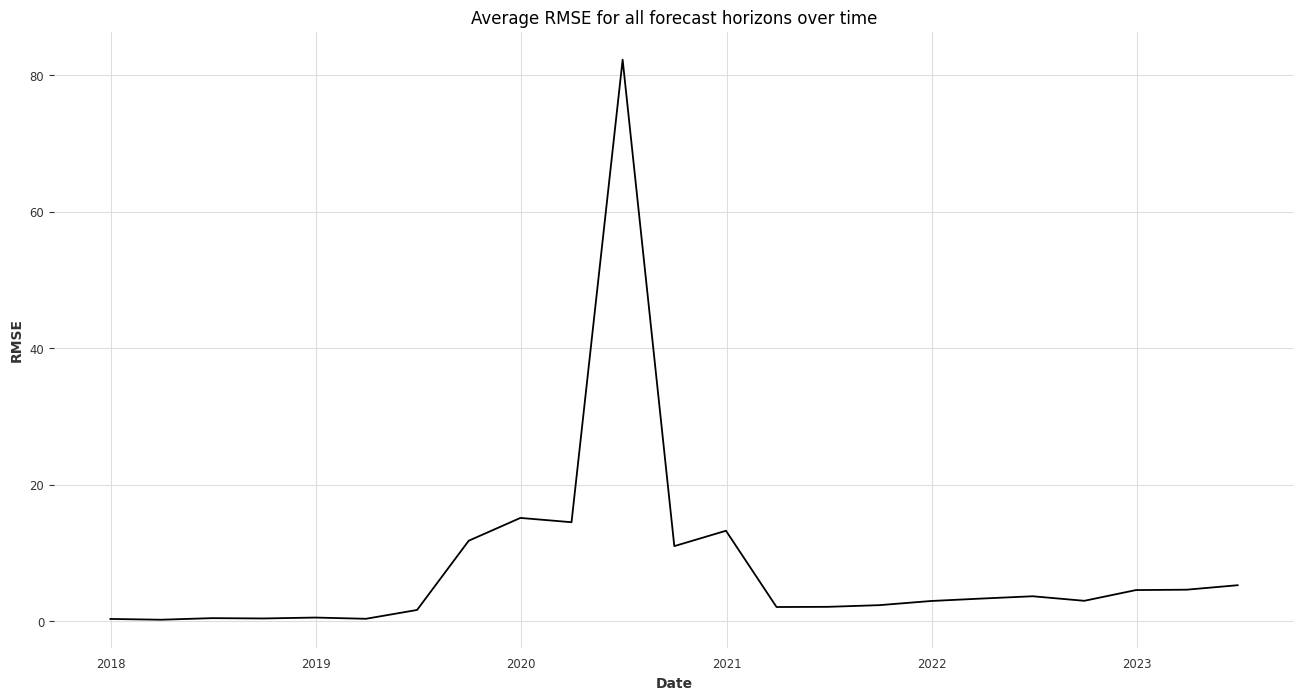

In [630]:
eval_scores = [x for x in autoreg_eval_results['scores']]
eval_dates = [x.index[0] for x in autoreg_eval_results['predictions']] # Shifted back for nowcast quarter start

charting.rmse_plot(
    eval_scores,
    eval_dates,
    'Average RMSE for all forecast horizons over time'
)

<Axes: title={'center': 'Average RMSE for all forecast horizons over time - pre 2019 Q3'}, xlabel='Date', ylabel='RMSE'>

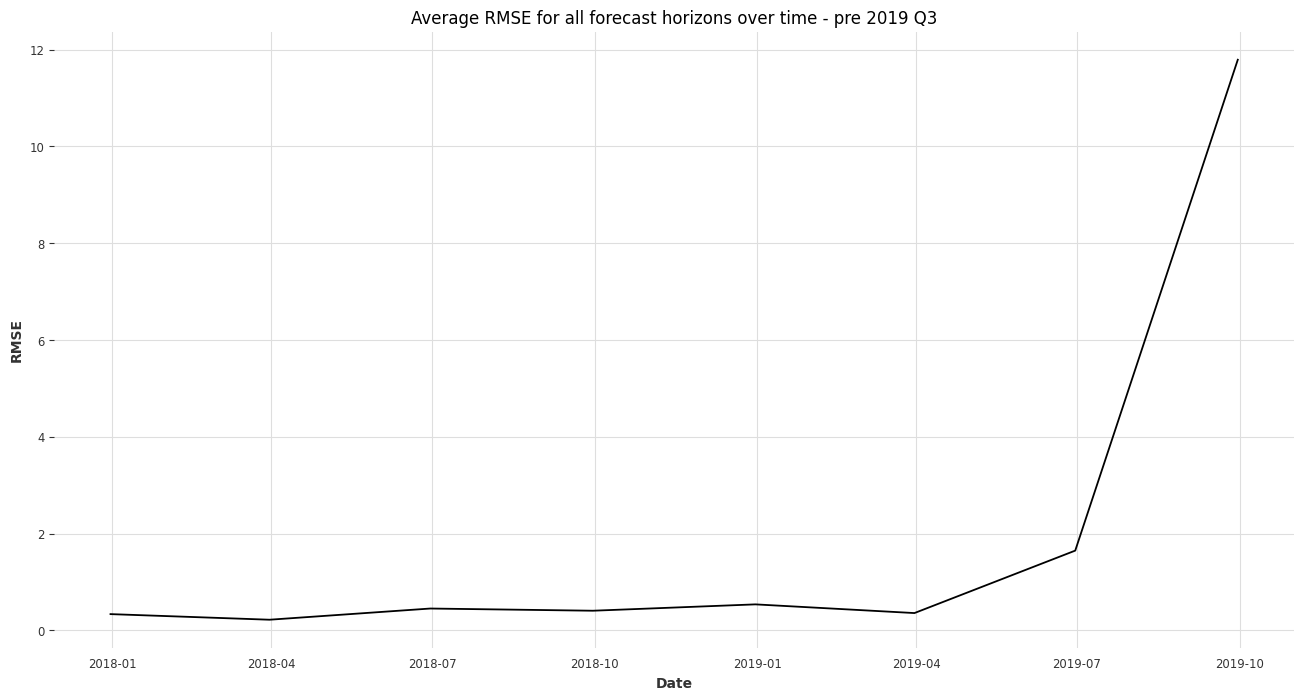

In [631]:
periods = len([dt for dt in eval_dates if dt <= pd.Timestamp('2019-Q4')])

charting.rmse_plot(
    eval_scores[:periods],
    eval_dates[:periods],
    'Average RMSE for all forecast horizons over time - pre 2019 Q3'
)

<Axes: title={'center': 'Model Nowcasts'}, xlabel='Date', ylabel='Quarterly GDP growth'>

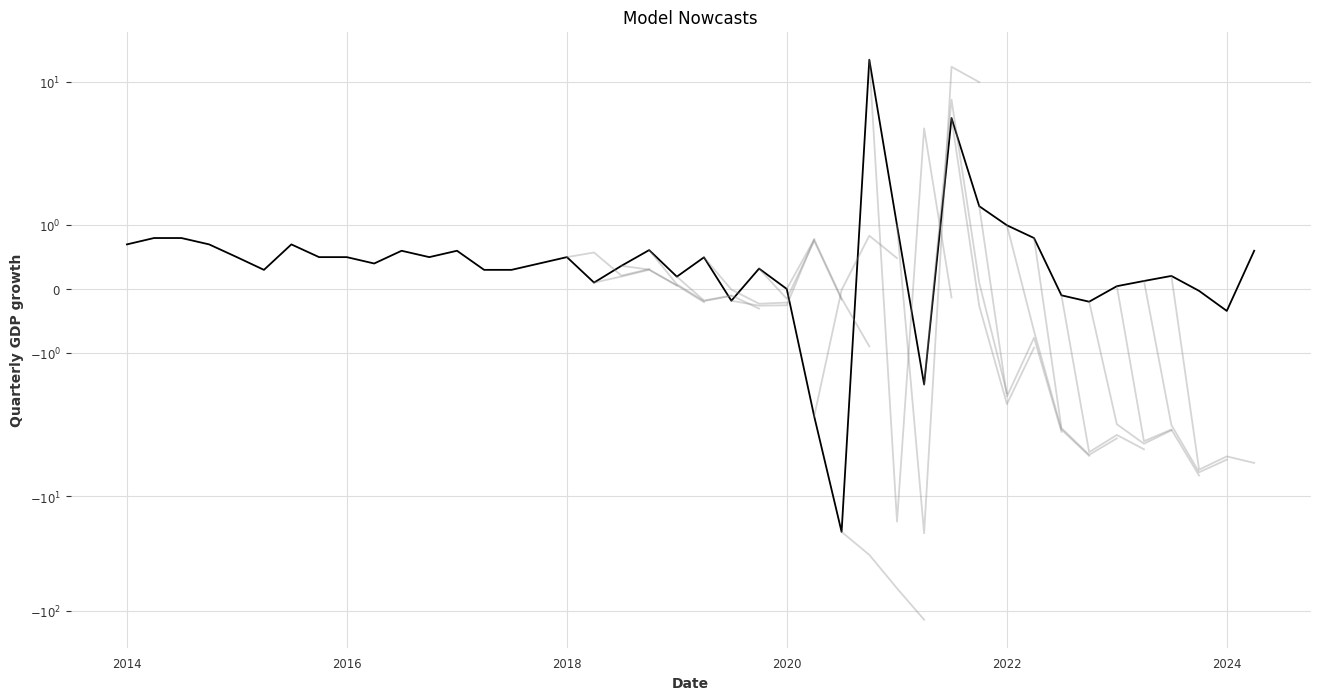

In [632]:
charting.hedgehog_plot(
    autoreg_eval_results,
    target_series = Y_q_trf[Y_q_trf.index > pd.Timestamp('2013-Q4')],
    log_axis=True
)

### Step 4.1: auto TS Model - COMMENTED OUT
* AutoTS is a python project, developed by (**CITE THE PACKAGE**). A genetic algorithm selects optimal (for the combination of forecast performance metrics used), combination of transformations and models to fit to the data, including applying ensemble techniques.
* Examples of transformations include:
    - Log difference
    - Box-Cox transformer
    - Seasonal adjustment
    - See appendix [X] for full list
* Examples of models include:
    - ARDL
    - Non-linear VAR
    - NeuralForecast
    - See Appendix [X] for full list
* In an attempt to avoid overfitting, a rigorous time-series cross-validation is applied, scored based on their out-of-sample forecast performance.

Github for citation: https://github.com/winedarksea/AutoTS/tree/master

* The model and transformer combination which AutoTS selected is...
    - List out the combination


In [633]:
# from autots.models.model_list import model_lists
# print(model_lists.keys()) # model_lists

# print(model_lists['best'])

In [634]:
# # Specify model

# model = AutoTS(
#     forecast_length=3,
#     model_list='fast_parallel',
#     # transformer_list='fast',
#     max_generations=15,
#     num_validations=5,
#     verbose=0,
#     holiday_country='UK',
# )
#
# # Fit model - will pick the model 
# model = model.fit(pd.concat([X, Y], axis=1))

# print(model)

In [635]:
# # Write the AutoTS model to pickle
# with open('model.pkl', 'wb') as f:
#     pickle.dump(model, f)

In [636]:
# wrapped_model = evaluation.ModelWrapper(
#     model, 
#     model_type='autots', 
#     target_column_name='Quarterly GDP growth'
# )

In [637]:
# evaluator = evaluation.Evaluator()

# autots_eval_results = evaluator.prequential_block(
#     model=wrapped_model,
#     loss_function=MeanSquaredError(square_root=True),
#     features=X_q,
#     targets=Y,
#     block_size=1,
#     forecast_horizon=3,
#     train_proportion=0.7
# )

In [638]:
# eval_scores = [x for x in autots_eval_results['scores']]
# eval_dates = [x.index[0]-pd.Timedelta(days=91) for x in autots_eval_results['predictions']] # Shifted back for nowcast quarter start

# charting.rmse_plot(
#     eval_scores,
#     eval_dates,
#     'Average RMSE for all forecast horizons over time'
# )

In [639]:
# charting.hedgehog_plot(
#     autots_eval_results,
#     target_series = Y[Y.index > pd.Timestamp('2016-Q2')],
#     log_axis=True
# )

### 4.2 Random Forest
* Random Forest Regression model - pretty standard
* N-estimators = 200
* First paper: Breiman, “Random Forests”, Machine Learning, 45(1), 5-32, 2001.

In [640]:
model = RandomForest(
    lags=8,
    lags_past_covariates=8,
    n_estimators=200,
    criterion="absolute_error",
    output_chunk_length=1
)

In [641]:
wrapped_model = evaluation.ModelWrapper(
    model, 
    model_type='darts', 
    target_column_name='Quarterly GDP growth'
)

In [642]:
evaluator = evaluation.Evaluator()

rnd_forest_eval_results = evaluator.prequential_block(
    model=wrapped_model,
    loss_function=MeanSquaredError(square_root=True),
    features=X_q_trf,
    targets=Y_q_trf,
    block_size=1,
    forecast_horizon=3,
    train_proportion=0.7
)

Running evaluation over expanding blocks:   0%|          | 0/25 [00:00<?, ?it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
`predict()` was called with `n > output_

Skipping block due to insufficient Y
Skipping block due to insufficient Y


<Axes: title={'center': 'Average RMSE for all forecast horizons over time'}, xlabel='Date', ylabel='RMSE'>

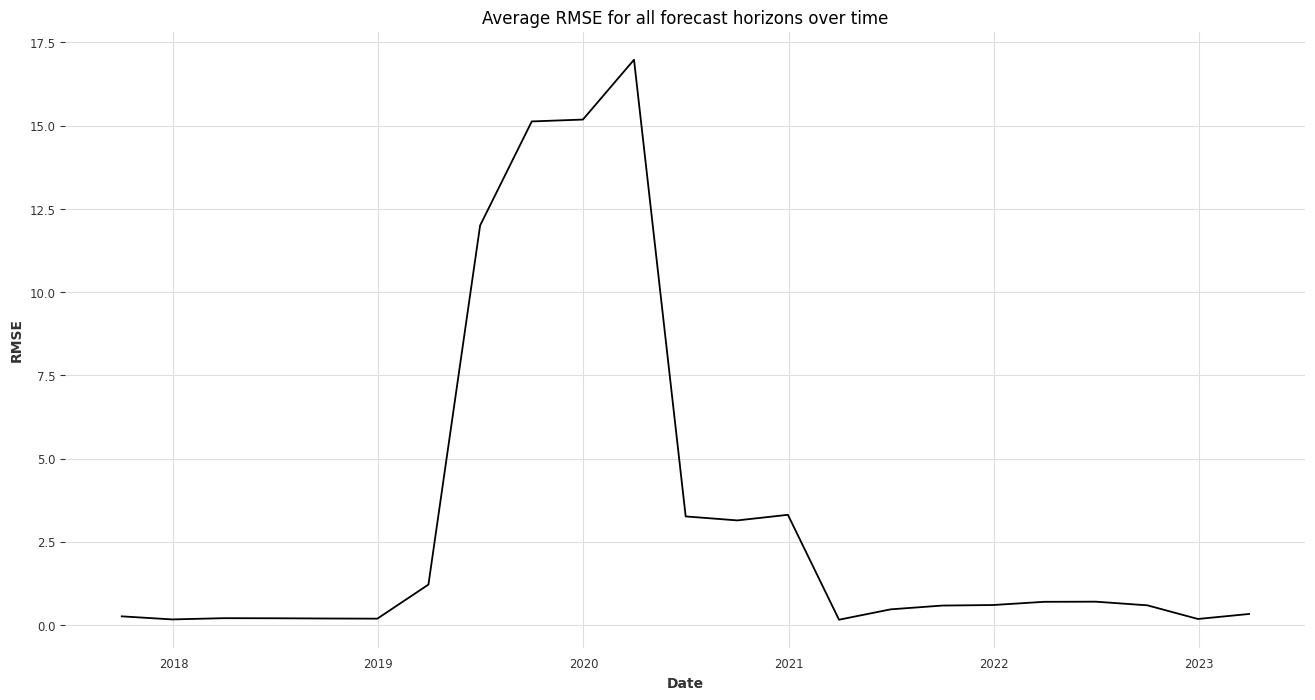

In [643]:
eval_scores = [x for x in rnd_forest_eval_results['scores']]
eval_dates = [x.index[0]-pd.Timedelta(days=91) for x in rnd_forest_eval_results['predictions']] # Shifted back for nowcast quarter start

charting.rmse_plot(
    eval_scores,
    eval_dates,
    'Average RMSE for all forecast horizons over time'
)

<Axes: title={'center': 'Model Nowcasts'}, xlabel='Date', ylabel='Quarterly GDP growth'>

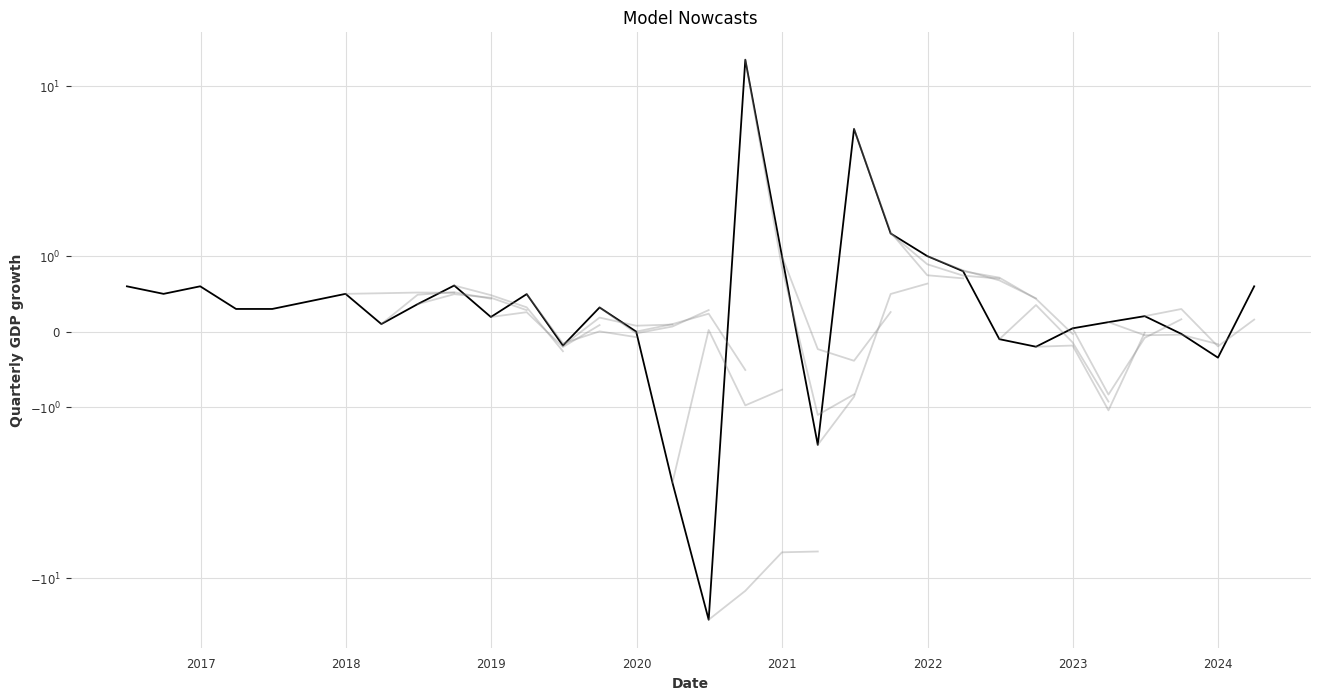

In [644]:
charting.hedgehog_plot(
    rnd_forest_eval_results,
    target_series = Y_q_trf[Y_q_trf.index > pd.Timestamp('2016-Q2')],
    log_axis=True
)

### 4.3 XGBoost Regression

* Standard machine-learning model based on gradient-boosting techniques
* XGBoost gained immense popularity after its release in 2016 - see this paper: (https://arxiv.org/abs/1603.02754)
* Basically - a souped-up random forest

In [645]:
from darts.models import XGBModel

model = XGBModel(
    lags=8,
    lags_past_covariates=8,
    output_chunk_length=1,
)

In [646]:
wrapped_model = evaluation.ModelWrapper(
    model, 
    model_type='darts', 
    target_column_name='Quarterly GDP growth'
)

In [647]:
evaluator = evaluation.Evaluator()

xgb_forest_eval_results = evaluator.prequential_block(
    model=wrapped_model,
    loss_function=MeanSquaredError(square_root=True),
    features=X_q_trf,
    targets=Y_q_trf,
    block_size=1,
    forecast_horizon=3,
    train_proportion=0.7 # 0.7 before
)

Running evaluation over expanding blocks:   0%|          | 0/25 [00:00<?, ?it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
`predict()` was called with `n > output_

Skipping block due to insufficient Y
Skipping block due to insufficient Y


<Axes: title={'center': 'Average RMSE for all forecast horizons over time'}, xlabel='Date', ylabel='RMSE'>

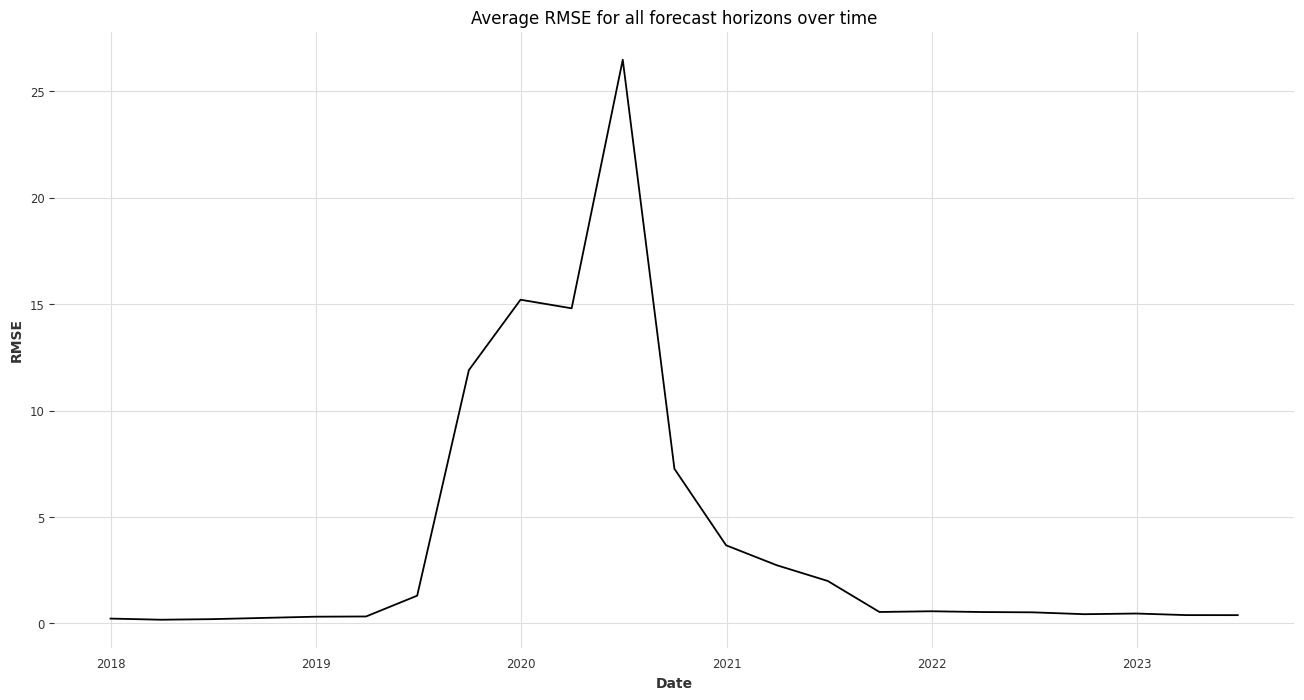

In [648]:
eval_scores = [x for x in xgb_forest_eval_results['scores']]
eval_dates = [x.index[0] for x in xgb_forest_eval_results['predictions']] # Shifted back for nowcast quarter start

charting.rmse_plot(
    eval_scores,
    eval_dates,
    'Average RMSE for all forecast horizons over time'
)

In [649]:
# periods = len([dt for dt in eval_dates if dt <= pd.Timestamp('2019-8-01')])

# charting.rmse_plot(
#     eval_scores[:periods],
#     eval_dates[:periods],
#     'Average RMSE for all forecast horizons over time - pre 2019 Q3'
# )

<Axes: title={'center': 'Model Nowcasts'}, xlabel='Date', ylabel='Quarterly GDP growth'>

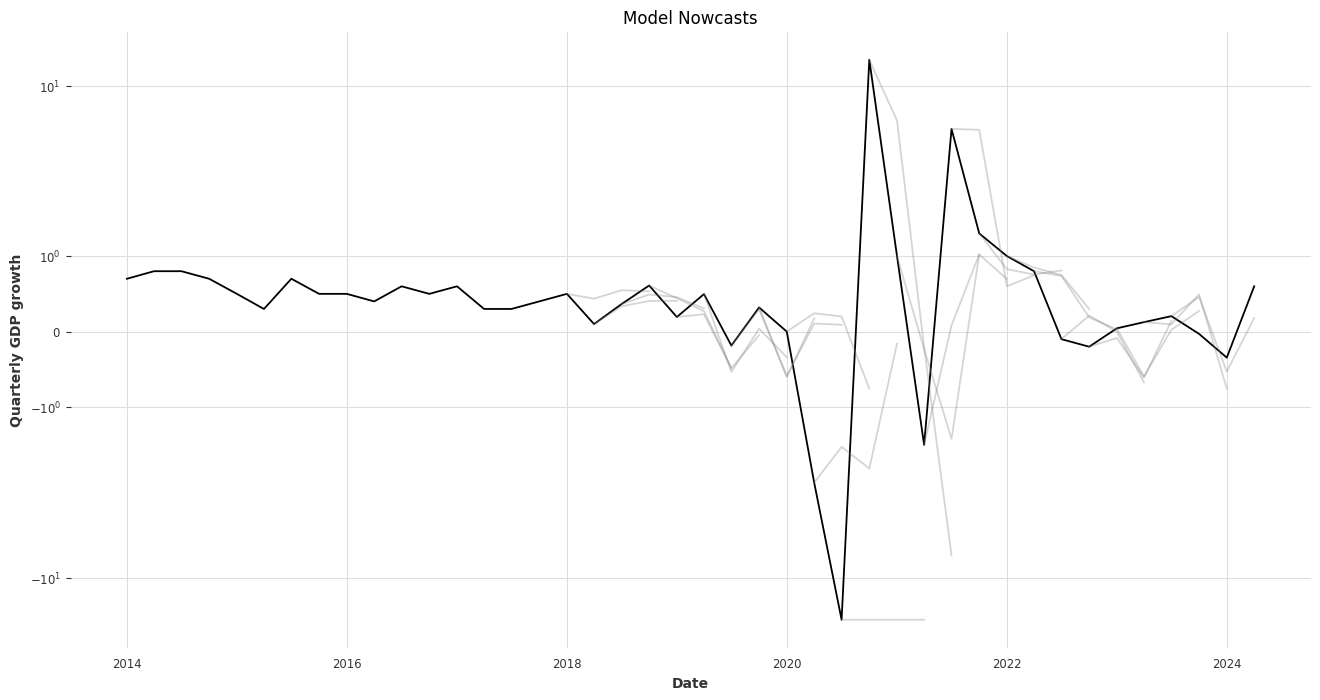

In [650]:
charting.hedgehog_plot(
    xgb_forest_eval_results,
    target_series = Y_q_trf[Y_q_trf.index > pd.Timestamp('2013-Q4')],
    log_axis=True
)

### 4.4 TiDE Model - COMMENTED OUT
* Encoder time series model
* Based on similar architecture to LLMs and modern AI

* Paper here: (A. Das et al. “Long-term Forecasting with TiDE: Time-series Dense Encoder”, http://arxiv.org/abs/2304.08424)

* TiDE (Time-series Dense Encoder) is a pure DL encoder-decoder architecture. It is special in that the temporal decoder can help mitigate the effects of anomalous samples on a forecast (Fig. 4 in the paper).

In [651]:
# b

In [652]:
# optimizer_kwargs = {
#     "lr": 1e-3,
# }

# # PyTorch Lightning Trainer arguments
# pl_trainer_kwargs = {
#     "gradient_clip_val": 1,
#     "max_epochs": 500,
#     "accelerator": "auto",
#     "callbacks": [],
# }

# # learning rate scheduler
# lr_scheduler_cls = torch.optim.lr_scheduler.ExponentialLR
# lr_scheduler_kwargs = {
#     "gamma": 0.999,
# }

# # early stopping (needs to be reset for each model later on)
# # this setting stops training once the the validation loss has not decreased by more than 1e-3 for 10 epochs
# early_stopping_args = {
#     "monitor": "val_loss",
#     "patience": 10,
#     "min_delta": 1e-3,
#     "mode": "min",
# }

# #
# common_model_args = {
#     "input_chunk_length": 12,  # lookback window
#     "output_chunk_length": 3,  # forecast/lookahead window
#     "optimizer_kwargs": optimizer_kwargs,
#     "pl_trainer_kwargs": pl_trainer_kwargs,
#     "lr_scheduler_cls": lr_scheduler_cls,
#     "lr_scheduler_kwargs": lr_scheduler_kwargs,
#     "likelihood": None,  # use a likelihood for probabilistic forecasts
#     "save_checkpoints": True,  # checkpoint to retrieve the best performing model state,
#     "force_reset": True,
#     "batch_size": 256,
#     # "random_state": 42,
# }

# model_tide_rin = TiDEModel(
#     **common_model_args, use_reversible_instance_norm=True, model_name="tide1"
# )

In [653]:
# y_train = y_train.astype('float32')
# X_train = X_train.astype('float32')

# y_test = y_test.astype('float32')
# X_test = X_test.astype('float32')

# y_train_darts = TimeSeries.from_series(y_train)
# X_train_darts = TimeSeries.from_dataframe(X_train)

# y_test_darts = TimeSeries.from_series(y_test)
# X_test_darts = TimeSeries.from_dataframe(X_test)

# model_tide_rin.fit(
#     series=y_train_darts,
#     past_covariates=X_train_darts,
# )

# model_tide_rin.predict(n=3).pd_series()

In [654]:
# wrapped_model = evaluation.ModelWrapper(
#     model_tide_rin, 
#     model_type='darts_TiDE', 
#     target_column_name='Quarterly GDP growth'
# )

# evaluator = evaluation.Evaluator()

# tide_eval_results = evaluator.prequential_block(
#     model=wrapped_model,
#     loss_function=MeanSquaredError(square_root=True),
#     features=X_q_trf,
#     targets=Y_q_trf,
#     block_size=1,
#     forecast_horizon=3,
#     train_proportion=0.7
# )

In [655]:
# eval_scores = [x for x in tide_eval_results['scores']]
# eval_dates = [x.index[0] for x in xgb_forest_eval_results['predictions']] # Shifted back for nowcast quarter start

# charting.rmse_plot(
#     eval_scores,
#     eval_dates,
#     'Average RMSE for all forecast horizons over time'
# )

In [656]:
# charting.hedgehog_plot(
#     tide_eval_results,
#     target_series = Y_q_trf[Y_q_trf.index > pd.Timestamp('2013-Q4')],
#     log_axis=False
# )

### 4.5 combined-MIDAS results
* Evaluate the results from the combined MIDAS

In [657]:
combined_midas_ss = pd.read_excel('MIDAS results.xlsx')
combined_midas_ss.index = pd.to_datetime(combined_midas_ss['Unnamed: 0'])
combined_midas_ss = combined_midas_ss.drop('Unnamed: 0', axis=1)
combined_midas_ss = combined_midas_ss.resample('QE-DEC').ffill()

combined_midas_ss['GDP_NC_2QA'] = combined_midas_ss['GDP_NC_2QA'].shift(-1) # Shift to aling to this quarter's forecast
combined_midas_ss['GDP_NC_3QA'] = combined_midas_ss['GDP_NC_3QA'].shift(-2)  # Shift to aling to this quarter's forecast

combined_midas_ss = combined_midas_ss.shift(-1) # Shift as the midas is setup to 'nowcast' and therefore stores data for the 'current quarter'
combined_midas_ss = combined_midas_ss.dropna(axis=0)

combined_midas_ss = combined_midas_ss.T

/var/folders/df/j998nyn11sdf0w5cf48pny6m0000gn/T/ipykernel_41501/2281691512.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  combined_midas_ss.index = pd.to_datetime(combined_midas_ss['Unnamed: 0'])


In [658]:
combined_midas_ss

Unnamed: 0,2007-09-30,2007-12-31,2008-03-31,2008-06-30,2008-09-30,2008-12-31,2009-03-31,2009-06-30,2009-09-30,2009-12-31,...,2022-03-31,2022-06-30,2022-09-30,2022-12-31,2023-03-31,2023-06-30,2023-09-30,2023-12-31,2024-03-31,2024-06-30
GDP_NC_1QA,0.692456,0.736318,0.795519,0.700714,0.565173,0.564203,0.586400,0.678900,0.734119,0.845321,...,-0.148368,-0.395975,-0.468639,-0.253757,-0.096645,0.166032,0.476415,0.285290,0.110022,0.309412
GDP_NC_2QA,0.782933,0.806809,0.838068,0.700562,0.591418,0.569564,0.630318,0.706097,0.814772,0.900646,...,-0.451702,-0.486838,-0.157986,-0.222105,0.307707,0.444746,0.443454,0.267250,0.098879,0.610931
GDP_NC_3QA,0.706133,0.746214,0.742690,0.543677,0.545972,0.527340,0.679392,0.702137,0.884824,0.908222,...,-1.280854,-0.637762,-0.262900,0.231860,0.419196,1.081682,0.467975,0.177158,0.552275,0.502474


Todo on this:
1. Double check we've aligned the forecasts correctly
2. Calculate the RMSE scores correctly
3. Add the real value on as for teh other models
4. Check the plotting works

In [659]:
c_midas_eval_results = {
    "scores": [],
    "predictions": []
}

In [660]:
loss_func = MeanSquaredError(square_root=True)
for date in combined_midas_ss:
    
    try:
        c_midas_eval_results['scores'].append(
            loss_func(
                Y.loc[date:date+pd.DateOffset(months=6)],
                combined_midas_ss[date].values
            )
        )
        
        c_midas_eval_results['predictions'].append(
            pd.Series(
                data=combined_midas_ss[date].values,
                index=Y.loc[date:date+pd.DateOffset(months=6)].index
            )
        )
    except ValueError:
        pass


<Axes: title={'center': 'Average RMSE for all forecast horizons over time'}, xlabel='Date', ylabel='RMSE'>

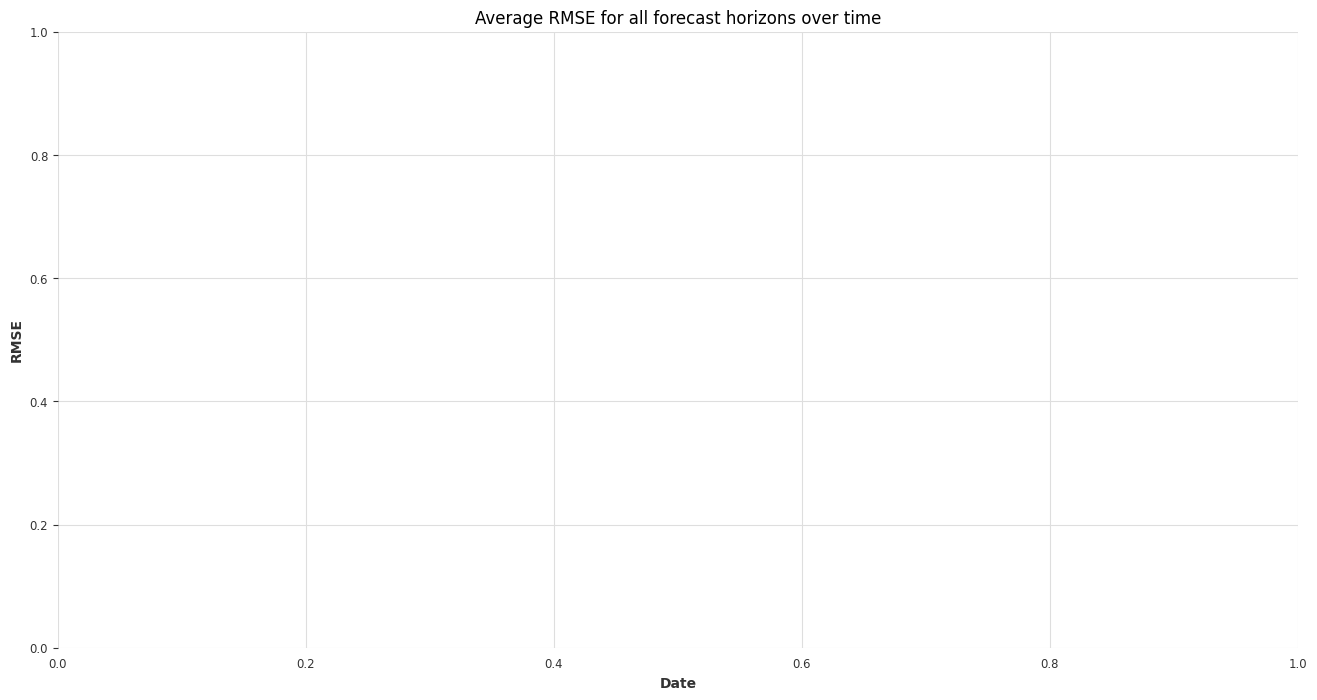

In [661]:
eval_scores = [x for x in c_midas_eval_results['scores']]
eval_dates = [x.index[0]-pd.Timedelta(days=91) for x in c_midas_eval_results['predictions']] # Shifted back for nowcast quarter start

charting.rmse_plot(
    eval_scores,
    eval_dates,
    'Average RMSE for all forecast horizons over time'
)

In [662]:
# charting.hedgehog_plot(
#     c_midas_eval_results,
#     target_series = Y[Y.index > pd.Timestamp('2016-Q2')],
#     log_axis=True
# )

In [663]:
# # Get Copper futures contracst prices
# tickers = [
#     'GC=F', # Gold December contracts
#     'GBPUSD=X', # GBP/USD
#     'HG=F', # Copper contracts
#     'CL=F', # Crude Oil October contracts
#     # '2YY=F', # 2 Year Yield futures
#     "^GSPC", # S&P 500
# ]

# tick_data = {}
# for ticker in tickers:
#     series_data = yf.Ticker(ticker).history(period='max')['Close']
#     series_data = series_data.resample('ME').mean()
#     series_data.index = series_data.index.tz_localize(None)
#     ticker = ticker.replace('=', '_')
#     ticker = ticker.replace('^', "")
#     tick_data[ticker] = series_data
    
# tick_df = pd.DataFrame.from_dict(tick_data)


In [664]:
# tick_df = pd.DataFrame.from_dict(tick_data)
# # tick_df.to_csv('FM_data.csv')

# Models including extra data

In [665]:
# # Load the extra data
# expanded_data = pd.ExcelFile('control_output-change.xlsm')

# with expanded_data as xl:
#     expanded_qind = pd.read_excel(xl, 'qind', index_col=0).dropna()
#     expanded_mind = pd.read_excel(xl, 'mind', index_col=0).dropna()

In [666]:
# expanded_X_q = pd.concat(
#     [expanded_qind, expanded_mind.resample('QE').mean()],
#     axis=1
# ).dropna()

# expanded_X_q = expanded_X_q.loc[expanded_X_q.index.intersection(Y_q.index)]
# # expanded_X_q.info()

In [667]:
# X_multi = pd.concat([X, tick_df], axis=1)
# # X_multi.info()

# X_multi = X_multi.dropna(thresh=8, axis=0)
# X_multi = X_multi.fillna(method='bfill')

# X_multi_q_avg = X_multi.resample('QE').mean().loc[Y_q.index.intersection(X_multi.resample('QE').mean().index)]

In [668]:
# # Midas implementation for testing
# midas = MIDAS(low_freq="QE")

# X_q_multi = midas.fit_transform(TimeSeries.from_dataframe(X_multi)).pd_dataframe()

### AR-X(P) with more data

In [669]:
model = AutoReg

wrapped_model = evaluation.ModelWrapper(
    model, 
    'autoreg',
    target_column_name='Quarterly GDP growth'
)

wrapped_model

<class 'statsmodels.tsa.ar_model.AutoReg'>

In [670]:
evaluator = evaluation.Evaluator()

exp_autoreg_eval_results = evaluator.prequential_block(
    model=wrapped_model,
    loss_function=MeanSquaredError(square_root=True),
    features=expanded_X_q_trf,
    targets=expanded_Y_q_trf,
    block_size=1,
    forecast_horizon=3,
    train_proportion=0.7 # 0.7 before
)

Running evaluation over expanding blocks:   0%|          | 0/25 [00:00<?, ?it/s]

Skipping block due to insufficient Y
Skipping block due to insufficient Y


/Users/lukasalemu/Downloads/ls/envs/harriet_diss/lib/python3.11/site-packages/sktime/performance_metrics/forecasting/_classes.py:615: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(
/Users/lukasalemu/Downloads/ls/envs/harriet_diss/lib/python3.11/site-packages/sktime/performance_metrics/forecasting/_classes.py:615: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(
/Users/lukasalemu/Downloads/ls/envs/harriet_diss/lib/python3.11/site-packages/sktime/performance_metrics/forecasting/_classes.py:615: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(
/Users/lukasalemu/Downloads/ls/envs/harriet_diss/lib/python3.11/site-pack

<Axes: title={'center': 'Average RMSE for all forecast horizons over time'}, xlabel='Date', ylabel='RMSE'>

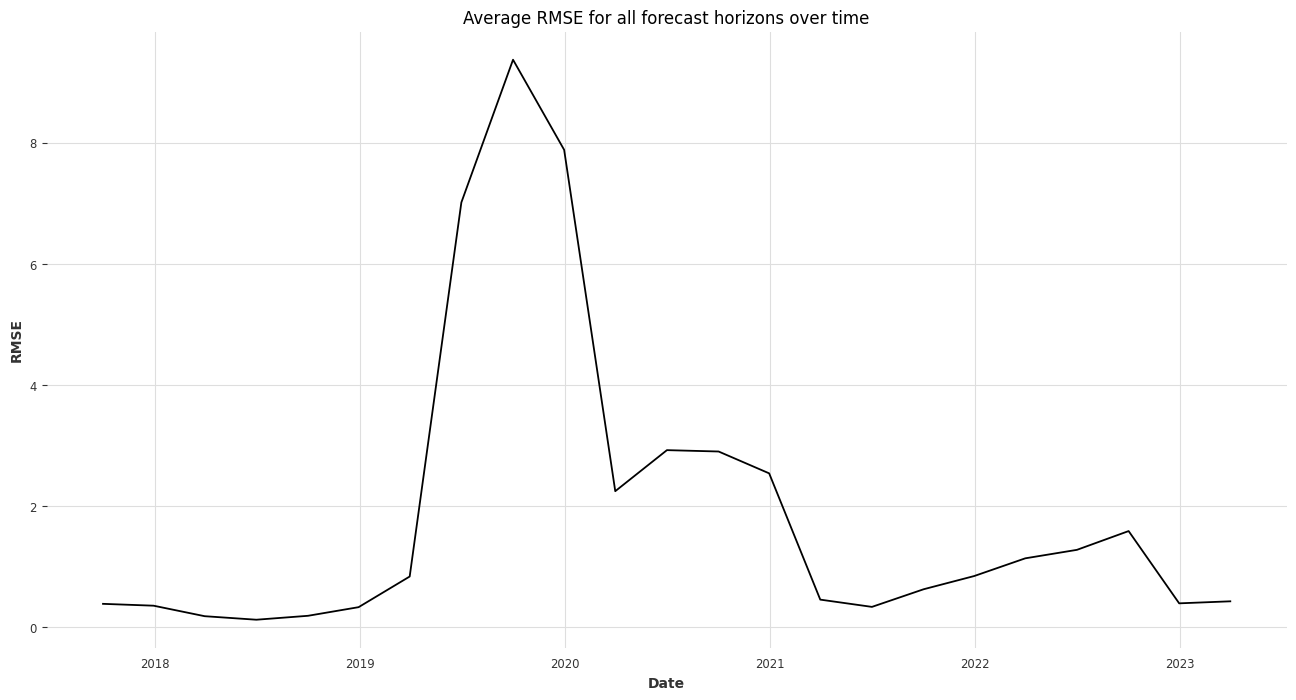

In [671]:
eval_scores = [x for x in exp_autoreg_eval_results['scores']]
eval_dates = [x.index[0]-pd.Timedelta(days=91) for x in exp_autoreg_eval_results['predictions']] # Shifted back for nowcast quarter start

charting.rmse_plot(
    eval_scores,
    eval_dates,
    'Average RMSE for all forecast horizons over time'
)

<Axes: title={'center': 'Model Nowcasts'}, xlabel='Date', ylabel='Quarterly GDP growth'>

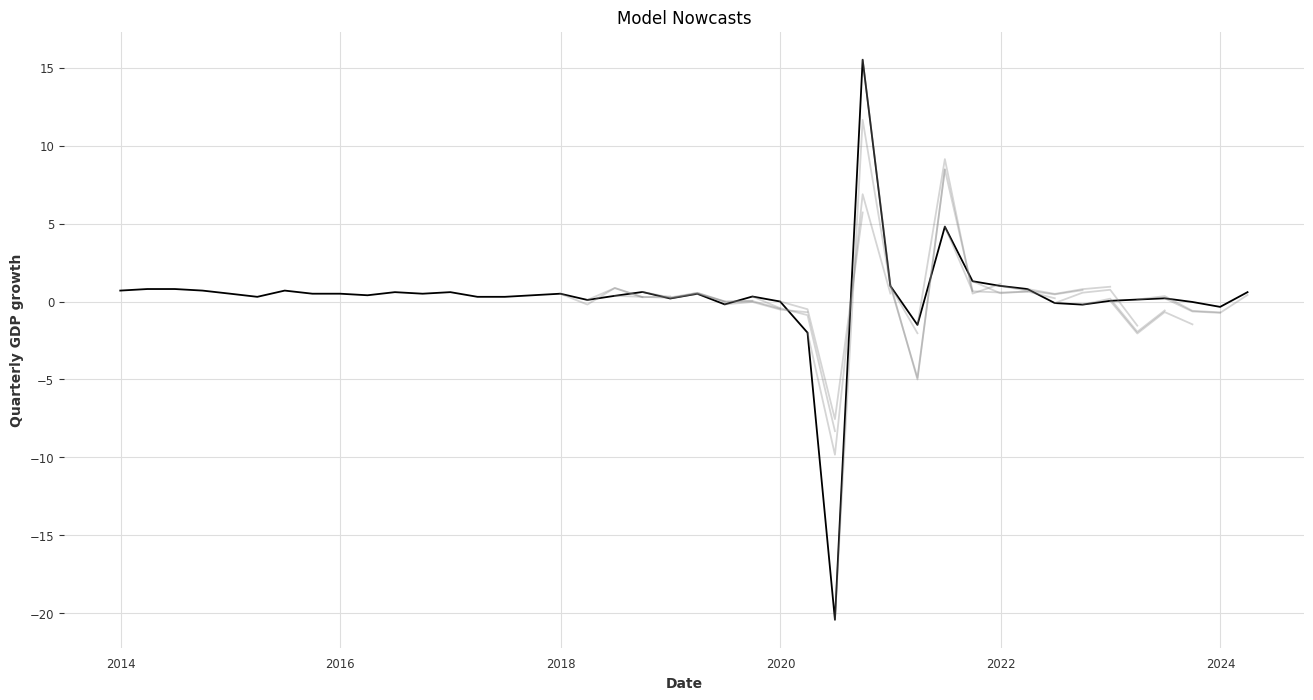

In [672]:
charting.hedgehog_plot(
    exp_autoreg_eval_results,
    target_series = Y_q[Y_q.index > pd.Timestamp('2013-Q4')],
    log_axis=False
)

### XGB more data

In [673]:
from darts.models import XGBModel

model = XGBModel(
    lags=8,
    lags_past_covariates=8,
    output_chunk_length=1,
)

wrapped_model = evaluation.ModelWrapper(
    model, 
    model_type='darts', 
    target_column_name='Quarterly GDP growth'
)

In [674]:
evaluator = evaluation.Evaluator()

exp_xgb_forest_eval_results = evaluator.prequential_block(
    model=wrapped_model,
    loss_function=MeanSquaredError(square_root=True),
    features=expanded_X_q_trf,
    targets=expanded_Y_q_trf,
    block_size=1,
    forecast_horizon=3,
    train_proportion=0.7 # 0.7 before
)

Running evaluation over expanding blocks:   0%|          | 0/25 [00:00<?, ?it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
`predict()` was called with `n > output_

Skipping block due to insufficient Y
Skipping block due to insufficient Y


<Axes: title={'center': 'Average RMSE for all forecast horizons over time'}, xlabel='Date', ylabel='RMSE'>

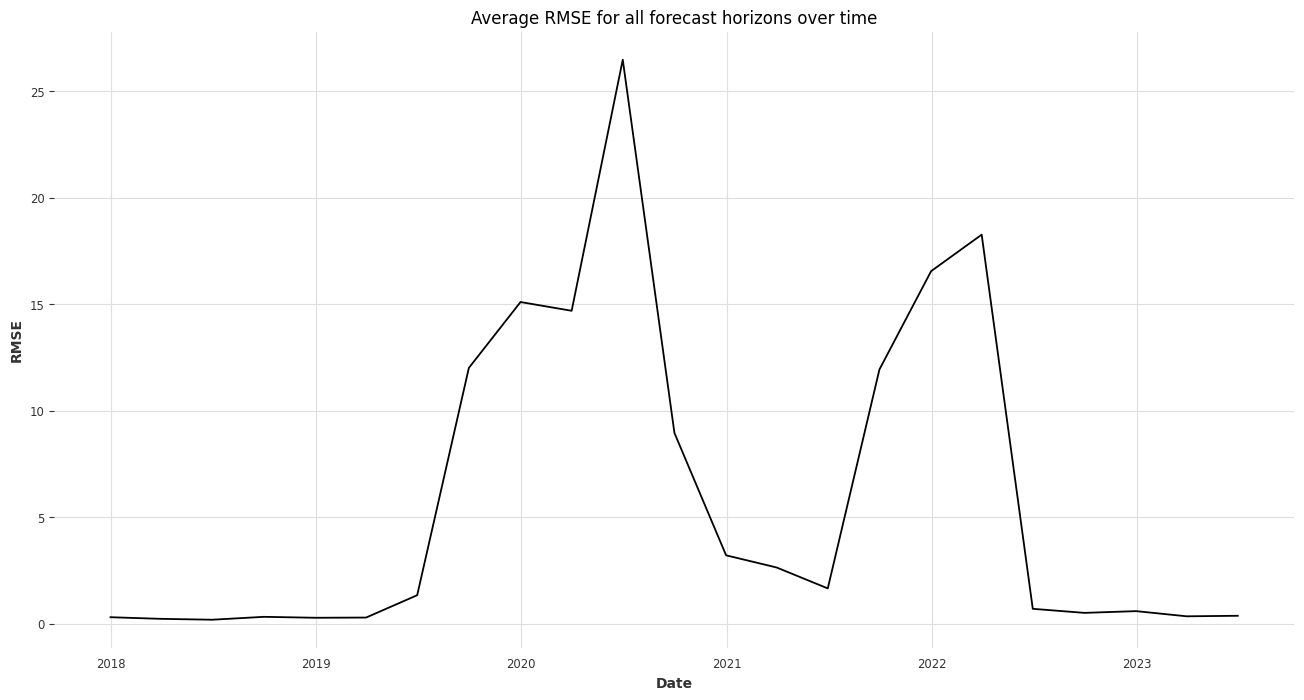

In [675]:
eval_scores = [x for x in exp_xgb_forest_eval_results['scores']]
eval_dates = [x.index[0] for x in exp_xgb_forest_eval_results['predictions']] # Shifted back for nowcast quarter start

charting.rmse_plot(
    eval_scores,
    eval_dates,
    'Average RMSE for all forecast horizons over time'
)

<Axes: title={'center': 'Model Nowcasts'}, xlabel='Date', ylabel='Quarterly GDP growth'>

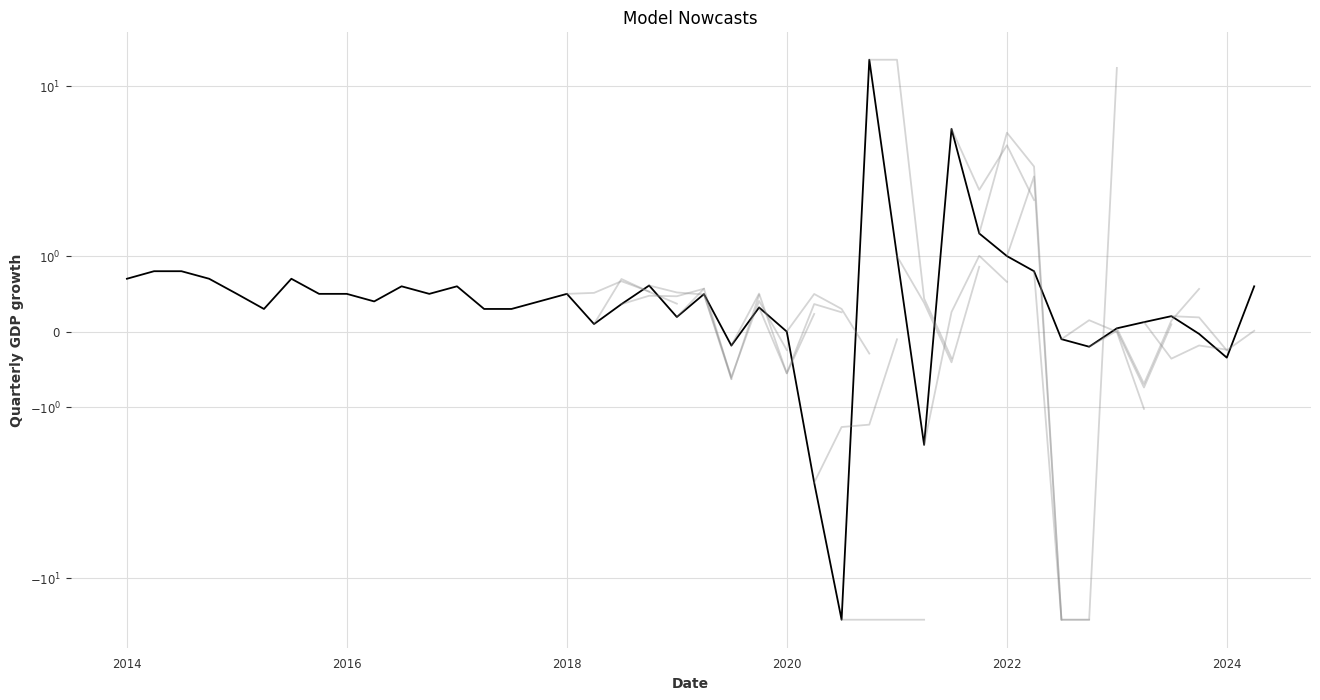

In [676]:
charting.hedgehog_plot(
    exp_xgb_forest_eval_results,
    target_series = Y_q_trf[Y_q_trf.index > pd.Timestamp('2013-Q4')],
    log_axis=True
)

### TiDE more data

In [677]:
# model_tide_rin = TiDEModel(
#     **common_model_args, use_reversible_instance_norm=True, model_name="tide1"
# )

# wrapped_model = evaluation.ModelWrapper(
#     model_tide_rin, 
#     model_type='darts_TiDE', 
#     target_column_name='Quarterly GDP growth'
# )

# evaluator = evaluation.Evaluator()

# exp_tide_eval_results = evaluator.prequential_block(
#     model=wrapped_model,
#     loss_function=MeanSquaredError(square_root=True),
#     features=expanded_X_q_trf,
#     targets=expanded_Y_q_trf,
#     block_size=1,
#     forecast_horizon=3,
#     train_proportion=0.7 # 0.7 before
# )

In [678]:
# eval_scores = [x for x in exp_tide_eval_results['scores']]
# eval_dates = [x.index[0] for x in exp_tide_eval_results['predictions']] # Shifted back for nowcast quarter start

# charting.rmse_plot(
#     eval_scores,
#     eval_dates,
#     'Average RMSE for all forecast horizons over time'
# )

In [679]:
# charting.hedgehog_plot(
#     exp_tide_eval_results,
#     target_series = Y_q[Y_q.index > pd.Timestamp('2013-Q4')],
#     log_axis=True
# )

### Random Forest more data

In [680]:
model = RandomForest(
    lags=8,
    lags_past_covariates=8,
    n_estimators=200,
    criterion="absolute_error",
    output_chunk_length=1
)

In [681]:
wrapped_model = evaluation.ModelWrapper(
    model, 
    model_type='darts', 
    target_column_name='Quarterly GDP growth'
)

In [682]:
evaluator = evaluation.Evaluator()

exp_rnd_forest_eval_results = evaluator.prequential_block(
    model=wrapped_model,
    loss_function=MeanSquaredError(square_root=True),
    features=expanded_X_q_trf,
    targets=expanded_Y_q_trf,
    block_size=1,
    forecast_horizon=3,
    train_proportion=0.7
)

Running evaluation over expanding blocks:   0%|          | 0/25 [00:00<?, ?it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
`predict()` was called with `n > output_

Skipping block due to insufficient Y
Skipping block due to insufficient Y


<Axes: title={'center': 'Average RMSE for all forecast horizons over time'}, xlabel='Date', ylabel='RMSE'>

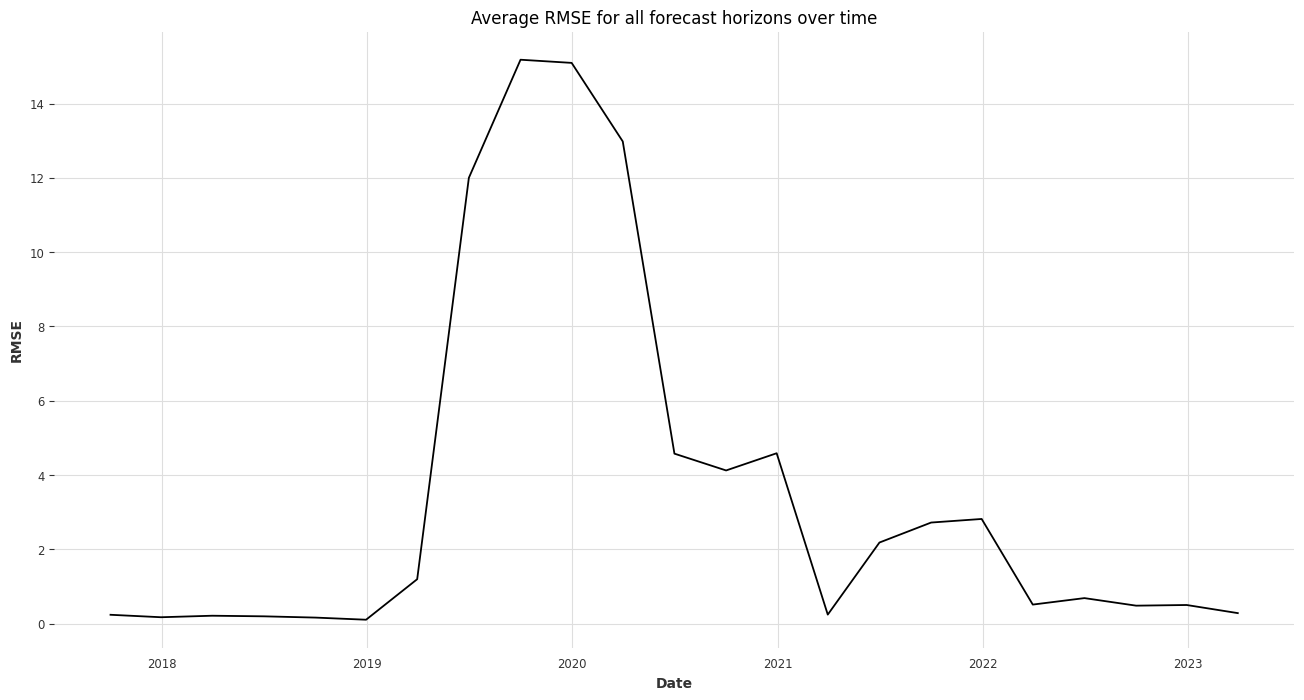

In [683]:
eval_scores = [x for x in exp_rnd_forest_eval_results['scores']]
eval_dates = [x.index[0]-pd.Timedelta(days=91) for x in exp_rnd_forest_eval_results['predictions']] # Shifted back for nowcast quarter start

charting.rmse_plot(
    eval_scores,
    eval_dates,
    'Average RMSE for all forecast horizons over time'
)

<Axes: title={'center': 'Model Nowcasts'}, xlabel='Date', ylabel='Quarterly GDP growth'>

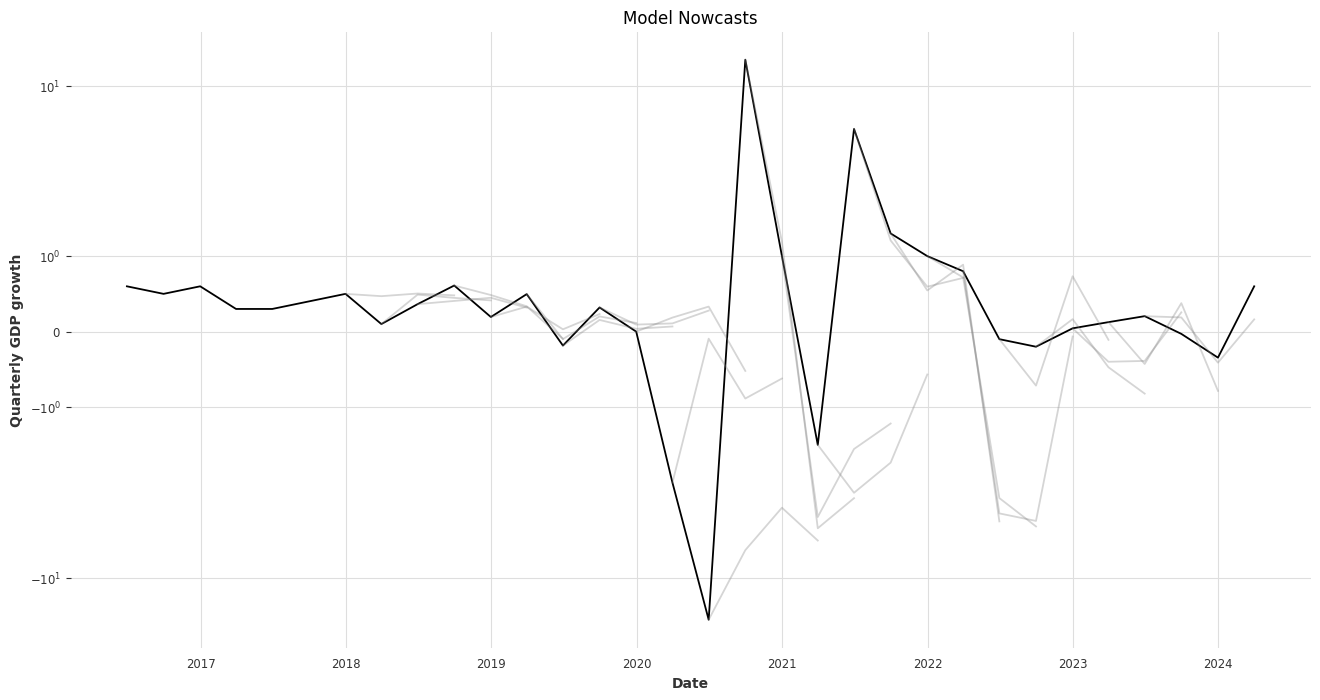

In [684]:
charting.hedgehog_plot(
    exp_rnd_forest_eval_results,
    target_series = Y_q_trf[Y_q_trf.index > pd.Timestamp('2016-Q2')],
    log_axis=True
)

In [685]:
# expanded_X_q_trf.plot()

# Table of results

### Normal sample

In [686]:
# Create series from each preds bundle
def create_df_from_preds(preds):
    q1_s = []
    q2_s = []
    q3_s = []

    nowcast_q = []
    for preds in preds['predictions']:
        nowcast_q.append(preds.index[0])
        q1_s.append(preds.values[1])
        q2_s.append(preds.values[2])
        q3_s.append(preds.values[3])
        # break
        
    q1_s = q1_s + [np.nan, np.nan]
    q2_s = [np.nan] + q2_s + [np.nan]
    q3_s = [np.nan, np.nan] + q3_s

    preds = pd.DataFrame(columns=['Q1', 'Q2', 'Q3'])
    preds['Q1'] = q1_s
    preds['Q2'] = q2_s
    preds['Q3'] = q3_s

    preds.index = pd.date_range(start=nowcast_q[0], periods=len(q1_s), freq='Q')

    preds = preds.astype(float)
    
    return preds 

autoreg_preds_series = create_df_from_preds(autoreg_eval_results)
xgb_preds_series = create_df_from_preds(xgb_forest_eval_results)
# tide_preds_series = create_df_from_preds(tide_eval_results)
rnd_forest_series = create_df_from_preds(rnd_forest_eval_results)

/var/folders/df/j998nyn11sdf0w5cf48pny6m0000gn/T/ipykernel_41501/226149065.py:24: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  preds.index = pd.date_range(start=nowcast_q[0], periods=len(q1_s), freq='Q')
/var/folders/df/j998nyn11sdf0w5cf48pny6m0000gn/T/ipykernel_41501/226149065.py:24: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  preds.index = pd.date_range(start=nowcast_q[0], periods=len(q1_s), freq='Q')
/var/folders/df/j998nyn11sdf0w5cf48pny6m0000gn/T/ipykernel_41501/226149065.py:24: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  preds.index = pd.date_range(start=nowcast_q[0], periods=len(q1_s), freq='Q')


In [687]:
combined_midas_ss = pd.read_excel('MIDAS results.xlsx')
combined_midas_ss.index = pd.to_datetime(combined_midas_ss['Unnamed: 0'])
combined_midas_ss = combined_midas_ss.drop('Unnamed: 0', axis=1)
combined_midas_ss = combined_midas_ss.resample('QE-DEC').ffill()

midas_preds_series = combined_midas_ss.dropna(thresh=1)
midas_preds_series = midas_preds_series.rename(columns={
    'GDP_NC_1QA': 'Q1',
    'GDP_NC_2QA': 'Q2',
    'GDP_NC_3QA': 'Q3'
})
midas_preds_series.index.name = 'date'

matching_indices = autoreg_preds_series.index.intersection(midas_preds_series.index)

midas_preds_series = midas_preds_series.loc[matching_indices]

/var/folders/df/j998nyn11sdf0w5cf48pny6m0000gn/T/ipykernel_41501/1505729543.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  combined_midas_ss.index = pd.to_datetime(combined_midas_ss['Unnamed: 0'])


In [688]:
def get_rmse_results(preds_series):
    mse = MeanSquaredError(square_root=True)
    
    matching_indices = preds_series.index.intersection(Y_q_trf.index)
    Y_selection = Y_q_trf.loc[matching_indices]
    
    q1 = mse(Y_selection, preds_series['Q1'])
    q2 = mse(Y_selection, preds_series['Q2'])
    q3 = mse(Y_selection, preds_series['Q3'])
    
    return q1, q2, q3

def get_rmse_results_pre2019Q3(preds_series):
    mse = MeanSquaredError(square_root=True)

    preds_pre_covid = preds_series.loc[preds_series.index <= pd.Timestamp("2019-Q4")]
    y_q_trf_pre_covid = Y_q_trf.loc[Y_q_trf.index <= pd.Timestamp("2019-Q4")]
    
    matching_indices = preds_pre_covid.index.intersection(y_q_trf_pre_covid.index)
    Y_selection = y_q_trf_pre_covid.loc[matching_indices]
    
    # Y_selection.plot()
    q1 = mse(Y_selection, preds_pre_covid['Q1'])
    q2 = mse(Y_selection, preds_pre_covid['Q2'])
    q3 = mse(Y_selection, preds_pre_covid['Q3'])
    
    return q1, q2, q3

In [689]:
print('Autoregressive model results for 1q, 2q, and 3q ahead forecasts: \n', get_rmse_results(autoreg_preds_series))
print('XGBoost model results for 1q, 2q, and 3q ahead forecasts: \n', get_rmse_results(xgb_preds_series))
print('Random Forest model results for 1q, 2q, and 3q ahead forecasts: \n', get_rmse_results(rnd_forest_series))
print('C-MIDAS model results for 1q, 2q, and 3q ahead forecasts: \n', get_rmse_results(midas_preds_series))

Autoregressive model results for 1q, 2q, and 3q ahead forecasts: 
 (8.980586271012559, 17.532277975144623, 25.74981740492436)
XGBoost model results for 1q, 2q, and 3q ahead forecasts: 
 (2.153679572774659, 8.491082539879473, 7.039776361031023)
Random Forest model results for 1q, 2q, and 3q ahead forecasts: 
 (3.5944645601005885, 6.233587013711832, 5.690185053611792)
C-MIDAS model results for 1q, 2q, and 3q ahead forecasts: 
 (5.276686757115811, 5.270986212119938, 5.257292775102745)


/Users/lukasalemu/Downloads/ls/envs/harriet_diss/lib/python3.11/site-packages/sktime/performance_metrics/forecasting/_classes.py:615: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(


In [690]:
print('Autoregressive model results for 1q, 2q, and 3q ahead forecasts - Pre COVID: \n', get_rmse_results_pre2019Q3(autoreg_preds_series))
print('XGBoost model results for 1q, 2q, and 3q ahead forecasts: - Pre COVID \n', get_rmse_results_pre2019Q3(xgb_preds_series))
print('Random Forest model results for 1q, 2q, and 3q ahead forecasts: - Pre COVID \n', get_rmse_results_pre2019Q3(rnd_forest_series))
print('C-MIDAS model results for 1q, 2q, and 3q ahead forecasts: - Pre COVID \n', get_rmse_results_pre2019Q3(midas_preds_series))

Autoregressive model results for 1q, 2q, and 3q ahead forecasts - Pre COVID: 
 (0.34175982454168813, 0.407137119757652, 0.4365840534623542)
XGBoost model results for 1q, 2q, and 3q ahead forecasts: - Pre COVID 
 (0.5272421339946655, 0.5473327284728629, 0.4977896601896673)
Random Forest model results for 1q, 2q, and 3q ahead forecasts: - Pre COVID 
 (0.32963484876352167, 0.34352133456610146, 0.3791011088637315)
C-MIDAS model results for 1q, 2q, and 3q ahead forecasts: - Pre COVID 
 (0.34170083217915737, 0.33702585007550506, 0.3444912976936784)


### Expanded Sample

In [691]:
exp_autoreg_preds_series = create_df_from_preds(exp_autoreg_eval_results)
exp_xgb_preds_series = create_df_from_preds(exp_xgb_forest_eval_results)
exp_rnd_forest_preds_series = create_df_from_preds(exp_rnd_forest_eval_results)

/var/folders/df/j998nyn11sdf0w5cf48pny6m0000gn/T/ipykernel_41501/226149065.py:24: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  preds.index = pd.date_range(start=nowcast_q[0], periods=len(q1_s), freq='Q')
/var/folders/df/j998nyn11sdf0w5cf48pny6m0000gn/T/ipykernel_41501/226149065.py:24: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  preds.index = pd.date_range(start=nowcast_q[0], periods=len(q1_s), freq='Q')
/var/folders/df/j998nyn11sdf0w5cf48pny6m0000gn/T/ipykernel_41501/226149065.py:24: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  preds.index = pd.date_range(start=nowcast_q[0], periods=len(q1_s), freq='Q')


In [692]:
# Get the expanded MIDAS data


In [693]:
print('Autoregressive model results for 1q, 2q, and 3q ahead forecasts - Expanded sample: \n', get_rmse_results(exp_autoreg_preds_series))
print('XGBoost model results for 1q, 2q, and 3q ahead forecasts: - Expanded sample \n', get_rmse_results(exp_xgb_preds_series))
print('Random Forest model results for 1q, 2q, and 3q ahead forecasts: - Expanded sample \n', get_rmse_results(exp_rnd_forest_preds_series))
# print('C-MIDAS model results for 1q, 2q, and 3q ahead forecasts: - Expanded sample \n', get_rmse_results(midas_preds_series))

Autoregressive model results for 1q, 2q, and 3q ahead forecasts - Expanded sample: 
 (7.990140009246121, 7.070403712875293, 6.859199214889281)
XGBoost model results for 1q, 2q, and 3q ahead forecasts: - Expanded sample 
 (4.556731499552121, 10.529930730456787, 9.73828230946709)
Random Forest model results for 1q, 2q, and 3q ahead forecasts: - Expanded sample 
 (4.483575674725733, 6.007144786980533, 5.832051495757879)


/Users/lukasalemu/Downloads/ls/envs/harriet_diss/lib/python3.11/site-packages/sktime/performance_metrics/forecasting/_classes.py:615: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(


In [696]:
print('Autoregressive model results for 1q, 2q, and 3q ahead forecasts - Expanded sample: \n', get_rmse_results_pre2019Q3(exp_autoreg_preds_series))
print('XGBoost model results for 1q, 2q, and 3q ahead forecasts: - Expanded sample \n', get_rmse_results_pre2019Q3(exp_xgb_preds_series))
print('Random Forest model results for 1q, 2q, and 3q ahead forecasts: - Expanded sample \n', get_rmse_results_pre2019Q3(exp_rnd_forest_preds_series))
# print('C-MIDAS model results for 1q, 2q, and 3q ahead forecasts: - Expanded sample \n', get_rmse_results(midas_preds_series))

Autoregressive model results for 1q, 2q, and 3q ahead forecasts - Expanded sample: 
 (0.5192281081545406, 0.5167204784331756, 0.42323310079389626)
XGBoost model results for 1q, 2q, and 3q ahead forecasts: - Expanded sample 
 (0.6079912407168695, 0.6352867457119251, 0.6134507213368473)
Random Forest model results for 1q, 2q, and 3q ahead forecasts: - Expanded sample 
 (0.29802656788916615, 0.3077609559670901, 0.3256869520829941)
